# Agrupamento Fuzzy

### Grupo
- Gabriel Camatta Zanotelli - 2018020140
- Nander Santos do Carmo - 2018019931 

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat  
from PIL import Image

## K-Means Algorithm 

### Carregamento dos dados

Utilizamos a biblioteca `matplotlib` para imprimir o conjunto de dados forcencidos no arquivo *fcm_dataset.mat* 

In [ ]:
# loading data set
# data (NxM) = DataFrame a ser clusterizado N observacoes e M features

data = loadmat('fcm_dataset.mat')
data = pd.DataFrame(data['x'])

lendata = len(data)
print('Numero de obervacoes: ', lendata)
nfeatures = data.shape[1]
print('Numero de atributos (features): ', nfeatures)

data_np = data.values
for i in range(len(data_np)):
        plt.scatter(data_np[i][0], data_np[i][1], s=7, color = 'blue')

### Inicialização dos centróides

É definido um número `K` de centróides (número de populações).
Aleatoriamente categorizamos cada um dos `lendata` indivíduos em uma das populações no vetor `idx` e uma matriz `partitions` de correlação de cada indivíduo com cada uma das populações.

In [ ]:
# Inicializacao
# partitions: np.array(N x K) - matriz de partições (pertinencia da observacao ao K-esimo grupo)

K = 4  # numero de grupos (clusters)

partitions = np.zeros([lendata, K])
idx = np.zeros(lendata)

# inicializacao aleatoria da matriz de partições
for i in range(1,lendata):
    rnd = np.random.randint(K)
    partitions[i][rnd] = 1
    idx[i] = rnd

print(partitions)
print(idx)

### Função de cálculo de centróides

Método que, dado o conjunto de dados e a matriz de correlação, calcula a posição do centróide no espaço de `M` variáveis.

In [196]:
# funcao que obtem os centroides
# centroids: np.array(K x N) - centroides (K vetores de M features) de cada grupo
def calc_centroids(data, partitions):
    nfeatures = data.shape[1]
    K = partitions.shape[1]
    centroids = np.zeros([K,nfeatures])
    data_np = data.values
    for i in range(K):
        idx_nonzero =  np.flatnonzero(partitions[:,i])
        data_i = data_np[idx_nonzero,:]
        centroids[i] = np.mean(data_i, axis=0)
    return centroids

### Calcula posição inicial dos centróides

Aplica o método acima para calcular a posição dos centróides no momento incial onde cada indivíduo foi categorizado aleatoriamente.

In [197]:
cent = np.zeros([K,nfeatures])
cent = calc_centroids(data, partitions)

### Plota centroides com dados

In [198]:
color_list = ['green', 'red', 'blue', 'purple', 'pink', 'orane']
def plot_centroids(data, cent, idx):
    data_val = data.values
    for i in range(1,len(data_val)):
        plt.scatter(data_val[i][0], data_val[i][1], s=7, color =color_list[int(idx[i])])
    for j in range(len(cent)):
        plt.plot(cent[j][0], cent[j][1], marker='o', markersize=10, markeredgecolor='white', markerfacecolor=color_list[j])

In [ ]:
plot_centroids(data, cent, idx)

### Implementação da função de categorização

A cada iteraçao da função abaixo serão recalculadas as categorizações feitas de cada indivíduo com relação a distância do mesmo à cada um dos centróides. O critério de parada final do nosso método será o momento em que não houver alteração na categorização de nenhum indivíduo entre duas iterações ou caso um número máximo de iterações seja alcançado.

In [199]:
def initialize_data(lendata, K):
    """
    Inicializacao aleatoria da matriz de partições
    :param lendata: Tamanho N da população
    :param K: Número de classes
    :return: Vetor de classificação com dados aleatórios
    """
    partitions = np.zeros([lendata, K])
    idx = np.zeros(lendata)
    
    for i in range(1,lendata):
        rnd = np.random.randint(K)
        partitions[i][rnd] = 1
        idx[i] = rnd
    
    return [idx, partitions]

In [200]:
def calc_new_class(data, cents):
    """
    Dada uma população e um vetor de posições dos K centróides, retorna a classificação atualziada da população.
    :param data: Dados em análise [N x M]
    :param cents: Vetor [K x M] de posições atuais dos centróides 
    :return: Vetor com. (1) Vetor [N x 1] com a classificação de cada um dos indivíduos em uma das K populações. (2) Matriz [N x K] com as partições de cada um dos indivíduos.
    """
    N = len(data)
    K = len(cents)
    data_np = data.values
    
    idx_aux = [0] * N
    partitions_aux = np.zeros([N, K]) #[[0]*K]*N
    
    for i in range(1,N):
        indiv = data_np[i]
        small_dist = 1000000
        small_dist_idx = 5
        for j in range(K):
            centroid = cents[j]
            aux_dist = np.subtract(indiv, centroid)
            dist = sum([x ** 2 for x in aux_dist])
            if dist < small_dist:
                small_dist = dist
                small_dist_idx = j
        partitions_aux[i][small_dist_idx] = 1
        idx_aux[i] = small_dist_idx
    
    return [idx_aux, partitions_aux]       

In [201]:
def kmeans(data, K, imax=10):
    
    initial_class = initialize_data(len(data), K)
    # idx = initial_class[0]
    part = initial_class[1]
    
    i_final = 0
    idx_cur = None
    idx_old = idx
    cent = None
    
    for i in range(imax):
        
        i_final += 1
        
        # Calcula centróides
        cent = calc_centroids(data, part)
        
        # Plota os centróides
        # plot_centroids(data, cent, old_idx)
        
        new_class = calc_new_class(data, cent)
        idx_cur = new_class[0]
        part = new_class[1]
        
        # if  str(idx_cur) == str(idx_old):
        #     break
        # else:
        #     old_idx = idx_cur
            
    return [cent, idx_cur, part, i_final]
    

## Aplicação do código com os dados de exemplo

In [ ]:
final = kmeans(data, 4)
print('Número de iterações:', final[3])
plot_centroids(data, final[0], final[1])

## Manipulação de Imagens

Utilizaremos o programa desenvolvido para classificação de cores das imagens passadas como exemplo. 

In [202]:
def photo_open(filename, rescale=1):
    photo = Image.open(filename)
    photo = photo.convert('RGB')
    photo =photo.resize( ( int(photo.size[0]/rescale), int(photo.size[1]/rescale) ), Image.ANTIALIAS)
    return photo

In [203]:
def pick_pixels(photo):
    n , m = photo.size
    ibagem = []
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            ibagem.append(list(pixels[i,j]) )
    return pd.DataFrame(ibagem)

In [204]:
def coloring(photo, labels, centers, rescale=1):
    n, m = photo.size
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            numb = [int(number) for number in centers[labels[i*m + j]] ] 
            pixels[i,j]= tuple(numb)
    photo = photo.resize( (int( photo.size[0]*rescale), int(photo.size[1]*rescale)), Image.ANTIALIAS)
    return photo

### Segmentação não-supervisionada

A imagem passada como argumento é dividida num vetor com os dados RGB de cada pixel.
Nesse problema de 3 variáveis, passamos um valor K que não só indicará o número de populações, mas a quantidade de cores que nossa imagem final terá.

C:\Users\gabri\AppData\Local\Temp\ipykernel_9252\1729234290.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  photo =photo.resize( ( int(photo.size[0]/rescale), int(photo.size[1]/rescale) ), Image.ANTIALIAS)
C:\Users\gabri\AppData\Local\Temp\ipykernel_9252\1080711406.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  photo = photo.resize( (int( photo.size[0]*rescale), int(photo.size[1]*rescale)), Image.ANTIALIAS)


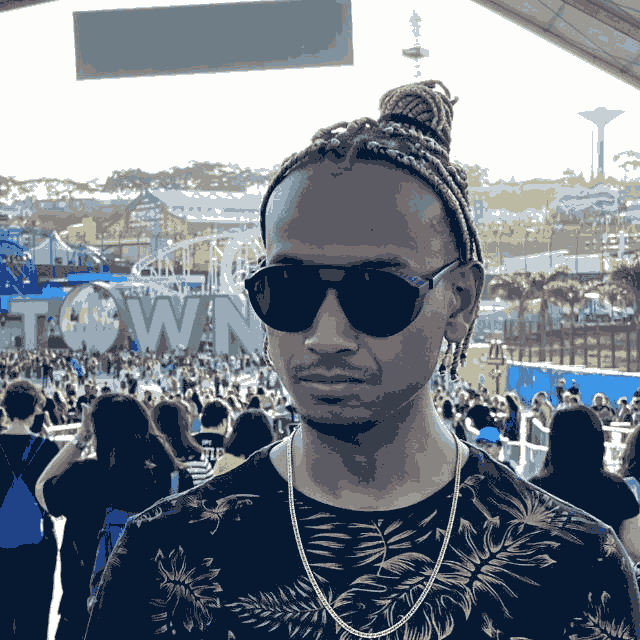

In [215]:
photo = photo_open('./ImagensTeste/Nander.jpg')
pixels = pick_pixels(photo)
final = kmeans(pixels, 15)
coloring(photo, final[1], final[0])